# HYPERPARAMETER TUNING FOR PROPENSITY SCORE WEIGHTING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import warnings
import time
from tqdm import tqdm  # For progress tracking TODO: Remove if not needed
import os
import itertools
from matplotlib.lines import Line2D
import json

# For better plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')

# Check if PyTorch is available
TORCH_AVAILABLE = False
try:
    import torch
    TORCH_AVAILABLE = True
    print("PyTorch is available")
except ImportError:
    print("PyTorch is not available")

# Import the permutation weighting implementation
from permutation_weighting.estimator import PW

# Function to generate Kang-Schafer data
def generate_kang_schafer_binary(n=1000, seed=42, misspecified=False):
    """
    Generate data according to the Kang-Schafer setup with binary treatment
    
    Parameters:
    -----------
    n: int
        Number of observations
    seed: int
        Random seed
    misspecified: bool
        Whether to return the misspecified transformations of covariates
        
    Returns:
    --------
    df: pd.DataFrame
        Data frame with columns: X1-X4 (covariates), A (treatment), Y (outcome), 
        Y1 (potential outcome under treatment), Y0 (potential outcome under control),
        and X1_mis to X4_mis (misspecified covariates, if requested)
    """
    np.random.seed(seed)
    
    # Generate covariates
    X = np.random.normal(0, 1, size=(n, 4))
    
    # Treatment assignment
    ps_linear = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    ps = expit(ps_linear)
    A = np.random.binomial(1, ps, size=n)
    
    # Generate potential outcomes
    Y1 = 210 + 1 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    Y0 = 210 + 0 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    
    # Observed outcome
    Y = A * Y1 + (1 - A) * Y0
    
    # Create DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'X3': X[:, 2],
        'X4': X[:, 3],
        'A': A,
        'Y': Y,
        'Y1': Y1,
        'Y0': Y0
    })
    
    # Add misspecified covariates if requested
    if misspecified:
        df['X1_mis'] = np.exp(X[:, 0]/2)
        df['X2_mis'] = X[:, 1] / (1 + np.exp(X[:, 0])) + 10
        df['X3_mis'] = (X[:, 0] * X[:, 2] / 25 + 0.6)**3
        df['X4_mis'] = (X[:, 1] + X[:, 3] + 20)**2
    
    return df


# Function to calculate true ATE
def true_ate(df):
    """Calculate the true average treatment effect"""
    return np.mean(df['Y1'] - df['Y0'])

# Function to estimate ATE using PW weights
def estimate_ate(df, weights):
    """Estimate ATE using PW weights"""
    # Normalize weights to sum to n
    n = len(df)
    normalized_weights = weights * n / np.sum(weights)
    
    # Weighted ATE estimate
    treated_indices = df['A'] == 1
    control_indices = df['A'] == 0
    
    weighted_treated_mean = np.sum(df.loc[treated_indices, 'Y'] * normalized_weights[treated_indices]) / np.sum(normalized_weights[treated_indices])
    weighted_control_mean = np.sum(df.loc[control_indices, 'Y'] * normalized_weights[control_indices]) / np.sum(normalized_weights[control_indices])
    
    return weighted_treated_mean - weighted_control_mean

PyTorch is available


# Function to perform hyperparameter tuning

In [2]:
# Function to perform cross-validation and record performance
def cross_validate_hyperparams(df, method, param_grid, method_name, n_folds=5, use_sgd=False, use_torch=False, seed=42):
    """
    Perform cross-validation to tune hyperparameters
    
    Parameters:
    -----------
    df: pd.DataFrame
        Data frame with columns: X1-X4, A, Y, Y1, Y0
    method: str
        Classification method ('logit', 'sgd_logit', 'neural_net', etc.)
    param_grid: dict
        Dictionary mapping parameter names to lists of values to try
    method_name: str
        Name to identify this method in results
    n_folds: int
        Number of cross-validation folds
    use_sgd: bool
        Whether to use SGD-based training
    use_torch: bool
        Whether to use PyTorch-based training
    seed: int
        Random seed for reproducibility
        
    Returns:
    --------
    results: pd.DataFrame
        Data frame with results of cross-validation
    """
    # Extract features and target
    feature_cols = [col for col in df.columns if col.startswith('X') and not col.endswith('_mis')]
    X = df[feature_cols].values
    A = df['A'].values
    y = df['Y'].values
    
    # Set up cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    # True ATE
    true_ate_value = true_ate(df)
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(itertools.product(*param_grid.values()))
    
    # Results storage
    results = []
    
    # Progress tracking
    total_combos = len(param_values)
    print(f"Running {total_combos} parameter combinations for {method_name}...")
    
    # Track time
    start_time = time.time()
    
    # Loop through parameter combinations
    for i, values in enumerate(param_values):
        params = dict(zip(param_names, values))
        
        # Print progress
        if i % max(1, total_combos // 10) == 0:
            elapsed = time.time() - start_time
            print(f"Combo {i+1}/{total_combos} - Elapsed: {elapsed:.1f}s")
        
        # Store fold results
        fold_results = []
        
        # Run cross-validation
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            # Split data
            X_train, X_test = X[train_idx], X[test_idx]
            A_train, A_test = A[train_idx], A[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Train PW model
            try:
                pw_result = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=method, 
                    classifier_params=params,
                    estimand='ATE',
                    num_replicates=1,  # Use 1 for speed during tuning
                    use_sgd=use_sgd,
                    use_torch=use_torch
                )
                
                # Save in-sample metrics
                in_sample_mse = pw_result['train'].get('MSEEvaluator', np.nan)
                in_sample_logloss = pw_result['train'].get('LogLossEvaluator', np.nan)
                
                # Apply to test set
                eval_data = {'A': A_test, 'X': X_test}
                eval_pw_result = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=method, 
                    classifier_params=params,
                    estimand='ATE',
                    num_replicates=1,
                    eval_data=eval_data,
                    use_sgd=use_sgd,
                    use_torch=use_torch
                )
                
                # Get out-of-sample metrics
                out_sample_mse = eval_pw_result['eval'].get('MSEEvaluator', np.nan)
                out_sample_logloss = eval_pw_result['eval'].get('LogLossEvaluator', np.nan)
                
                # Calculate estimated ATE
                df_train = pd.DataFrame({
                    'X1': X_train[:, 0], 'X2': X_train[:, 1], 
                    'X3': X_train[:, 2], 'X4': X_train[:, 3],
                    'A': A_train, 'Y': y_train
                })
                est_ate = estimate_ate(df_train, pw_result['weights'])
                
                # Calculate absolute error in ATE
                ate_error = abs(est_ate - true_ate_value)
                
                # Save results
                fold_result = {
                    'fold': fold,
                    'in_sample_mse': in_sample_mse,
                    'in_sample_logloss': in_sample_logloss,
                    'out_sample_mse': out_sample_mse,
                    'out_sample_logloss': out_sample_logloss,
                    'ate_error': ate_error,
                    'converged': pw_result.get('convergence_info', {}).get('converged', True)
                }
                
                fold_results.append(fold_result)
            except Exception as e:
                print(f"Error with params {params} for {method_name} in fold {fold}: {str(e)}")
                continue
        
        # Skip if no valid results
        if not fold_results:
            continue
        
        # Average results across folds
        mean_results = {
            k: np.mean([r[k] for r in fold_results if k in r and not np.isnan(r[k])]) 
            for k in ['in_sample_mse', 'in_sample_logloss', 'out_sample_mse', 'out_sample_logloss', 'ate_error']
        }
        
        # Calculate standard errors
        std_results = {
            f"{k}_std": np.std([r[k] for r in fold_results if k in r and not np.isnan(r[k])]) / np.sqrt(len(fold_results))
            for k in ['in_sample_mse', 'in_sample_logloss', 'out_sample_mse', 'out_sample_logloss', 'ate_error']
        }
        
        # Save parameter combination results with method name
        result = {**params, **mean_results, **std_results, 'method': method_name}
        
        # Convert any lists in params to strings for safe storage
        for k, v in params.items():
            if isinstance(v, list):
                result[k] = str(v)
        
        results.append(result)
    
    return pd.DataFrame(results)

# VISUALIZATION

In [3]:
def generate_model_performance_plots(results_dict, output_dir='tuning_results'):
    """
    Generate plots comparing model performance
    
    Parameters:
    -----------
    results_dict: dict
        Dictionary mapping method names to DataFrames of results
    output_dir: str
        Directory to save plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Combine results
    combined_results = pd.concat(results_dict.values(), ignore_index=True)
    
    # Define colors for each method
    methods = combined_results['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = dict(zip(methods, colors))
    
    # Create legend elements
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=method_colors[method], markersize=10, label=method)
        for method in methods
    ]
    
    # Plot 1: ATE Error vs. In-sample Log Loss
    plt.figure(figsize=(12, 8))
    
    for method in methods:
        method_data = combined_results[combined_results['method'] == method]
        plt.scatter(
            method_data['in_sample_logloss'], 
            method_data['ate_error'],
            alpha=0.7, s=60, color=method_colors[method],
            label=method
        )
    
    plt.xlabel('PW log-loss (in-sample)', fontsize=14)
    plt.ylabel('Absolute Causal Error (in-sample)', fontsize=14)
    plt.title('In-sample Causal Error vs. In-sample PW Loss', fontsize=16)
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/in_sample_comparison.png', dpi=300)
    
    # Plot 2: ATE Error vs. Out-of-sample Log Loss
    plt.figure(figsize=(12, 8))
    
    for method in methods:
        method_data = combined_results[combined_results['method'] == method]
        plt.scatter(
            method_data['out_sample_logloss'], 
            method_data['ate_error'],
            alpha=0.7, s=60, color=method_colors[method],
            label=method
        )
    
    plt.xlabel('PW log-loss (out-of-sample)', fontsize=14)
    plt.ylabel('Absolute Causal Error (in-sample)', fontsize=14)
    plt.title('In-sample Causal Error vs. Out-of-sample PW Loss', fontsize=16)
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/out_sample_comparison.png', dpi=300)
    
    # Find best configuration for each method
    best_configs = {}
    for method in methods:
        method_data = combined_results[combined_results['method'] == method]
        if not method_data.empty:
            best_idx = method_data['ate_error'].idxmin()
            best_configs[method] = {
                'ate_error': method_data.loc[best_idx, 'ate_error'],
                'in_sample_logloss': method_data.loc[best_idx, 'in_sample_logloss'],
                'out_sample_logloss': method_data.loc[best_idx, 'out_sample_logloss']
            }
            
            # Add parameters (excluding method and metrics)
            for col in method_data.columns:
                if col not in ['method', 'in_sample_mse', 'in_sample_logloss', 
                               'out_sample_mse', 'out_sample_logloss', 'ate_error',
                               'in_sample_mse_std', 'in_sample_logloss_std', 
                               'out_sample_mse_std', 'out_sample_logloss_std', 'ate_error_std']:
                    best_configs[method][col] = method_data.loc[best_idx, col]
    
    # Save best configurations to JSON
    with open(f'{output_dir}/best_configs.json', 'w') as f:
        json.dump(best_configs, f, indent=4)
    
    # Print best configurations
    print("\nBest configuration for each method:")
    for method, config in best_configs.items():
        print(f"{method}:")
        print(f"  ATE Error: {config['ate_error']:.4f}")
        print(f"  In-sample Log Loss: {config['in_sample_logloss']:.4f}")
        print(f"  Out-of-sample Log Loss: {config['out_sample_logloss']:.4f}")
        
        # Print parameters (excluding metrics)
        print("  Parameters:")
        for k, v in config.items():
            if k not in ['ate_error', 'in_sample_logloss', 'out_sample_logloss']:
                print(f"    {k}: {v}")
        print()
    
    return best_configs

# FINAL MODEL EVALUATION

In [4]:
def final_model_evaluation(df, methods_to_eval, output_dir='tuning_results', seed=42):
    """
    Train final models and generate ROC curves
    
    Parameters:
    -----------
    df: pd.DataFrame
        Data frame with columns: X1-X4, A, Y, Y1, Y0
    methods_to_eval: list
        List of (method_name, method_config) tuples to evaluate
    output_dir: str
        Directory to save plots
    seed: int
        Random seed
    """
    # Extract features and target
    feature_cols = [col for col in df.columns if col.startswith('X') and not col.endswith('_mis')]
    X = df[feature_cols].values
    A = df['A'].values
    
    # Set up cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Results for ROC curves
    roc_results = {method_name: {'tpr': [], 'fpr': [], 'auc': []} for method_name, _ in methods_to_eval}
    
    # Define colors for ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods_to_eval)))
    method_colors = dict(zip([name for name, _ in methods_to_eval], colors))
    
    # Evaluate each method
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        A_train, A_test = A[train_idx], A[test_idx]
        
        for method_name, config in methods_to_eval:
            try:
                # Convert string parameters back to appropriate types if needed
                fixed_params = config['params'].copy()
                for k, v in fixed_params.items():
                    if isinstance(v, str) and v.startswith('[') and v.endswith(']'):
                        # Convert string representation of list back to list
                        try:
                            fixed_params[k] = eval(v)
                        except:
                            pass
                
                # Train model
                pw_result = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=config['method'], 
                    classifier_params=fixed_params,
                    estimand='ATE',
                    num_replicates=1,
                    use_sgd=config.get('use_sgd', False),
                    use_torch=config.get('use_torch', False)
                )
                
                # Create balanced datasets for ROC calculation
                # For simplicity, we'll create a stacked dataset of permuted and observed data
                n = len(X_test)
                
                # Create permuted data
                np.random.seed(seed + fold)
                permuted_idx = np.random.permutation(n)
                
                # Features for classification
                X_eval = np.vstack([X_test, X_test])
                A_eval = np.concatenate([A_test[permuted_idx], A_test])
                
                # Labels: 1 for permuted, 0 for observed
                y_true = np.concatenate([np.ones(n), np.zeros(n)])
                
                # Apply model to get probabilities
                eval_data = {'A': A_eval, 'X': X_eval}
                pw_eval = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=config['method'], 
                    classifier_params=fixed_params,
                    estimand='ATE',
                    eval_data=eval_data,
                    num_replicates=1,
                    use_sgd=config.get('use_sgd', False),
                    use_torch=config.get('use_torch', False)
                )
                
                # Extract probabilities from weights
                weights = pw_eval['weights']
                y_score = weights / (1 + weights)
                
                # Calculate ROC
                fpr, tpr, _ = roc_curve(y_true, y_score)
                roc_auc = auc(fpr, tpr)
                
                # Store results
                roc_results[method_name]['fpr'].append(fpr)
                roc_results[method_name]['tpr'].append(tpr)
                roc_results[method_name]['auc'].append(roc_auc)
                
            except Exception as e:
                print(f"Error with {method_name} in fold {fold}: {str(e)}")
                continue
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for method_name, result in roc_results.items():
        if not result['auc']:
            print(f"No valid results for {method_name}")
            continue
            
        # Calculate mean AUC
        mean_auc = np.mean(result['auc'])
        
        # Interpolate to get average ROC curve
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        
        for i in range(len(result['fpr'])):
            interp_tpr = np.interp(mean_fpr, result['fpr'][i], result['tpr'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        
        # Plot average ROC curve
        color = method_colors.get(method_name, 'b')
        plt.plot(
            mean_fpr, mean_tpr,
            label=f'{method_name} (AUC = {mean_auc:.3f})',
            lw=2, alpha=0.8, color=color
        )
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves for Different Models', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    
    # Save plot
    plt.tight_layout()
    plt.savefig(f'{output_dir}/roc_curves.png', dpi=300)
    plt.close()

# MAIN FUNCTION 

Generating Kang-Schafer data...
Generated data with 2000 observations
True ATE: 0.9484

Tuning Standard Logistic Regression...
Running 18 parameter combinations for Standard Logistic...
Combo 1/18 - Elapsed: 0.0s
Combo 2/18 - Elapsed: 0.3s
Combo 3/18 - Elapsed: 0.5s
Combo 4/18 - Elapsed: 0.7s
Combo 5/18 - Elapsed: 0.9s
Error with params {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'} for Standard Logistic in fold 0: l1_ratio must be specified when penalty is elasticnet.
Error with params {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'} for Standard Logistic in fold 1: l1_ratio must be specified when penalty is elasticnet.
Error with params {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'} for Standard Logistic in fold 2: l1_ratio must be specified when penalty is elasticnet.
Error with params {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'} for Standard Logistic in fold 3: l1_ratio must be specified when penalty is elasticnet.
Error with params {'C': 0.1, 'penalty':

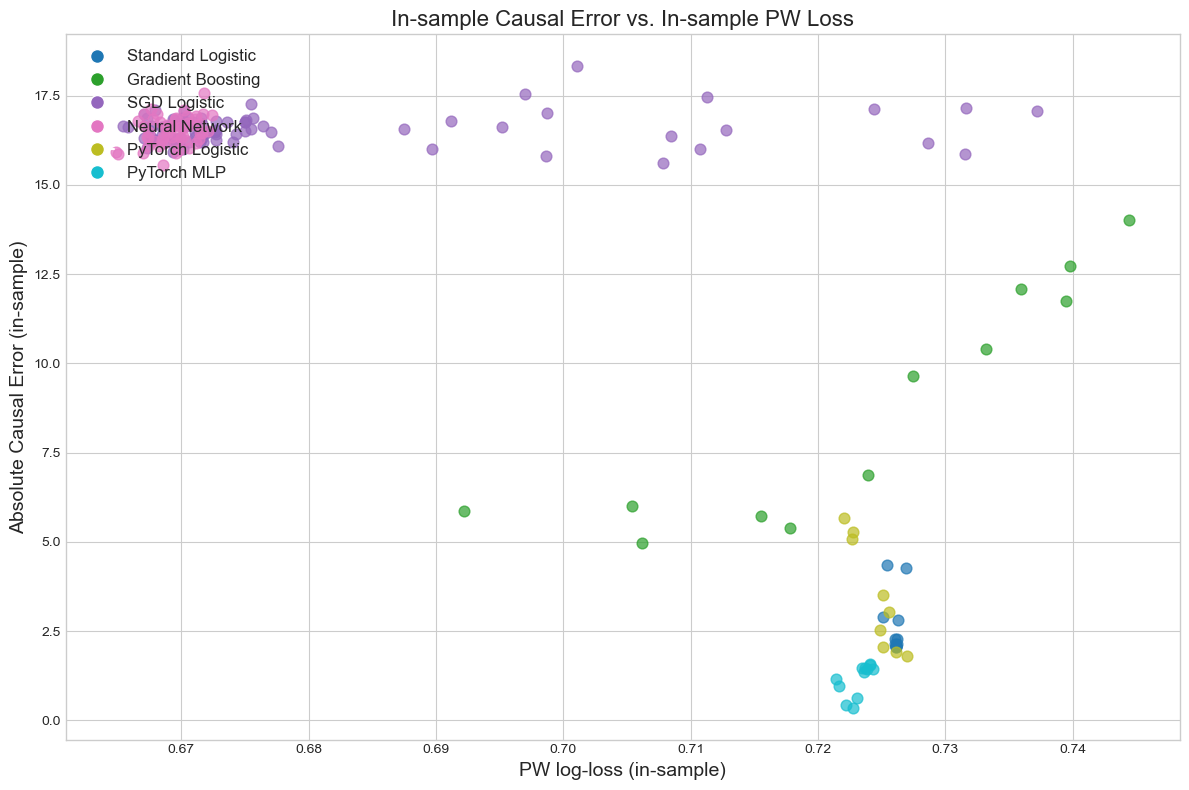

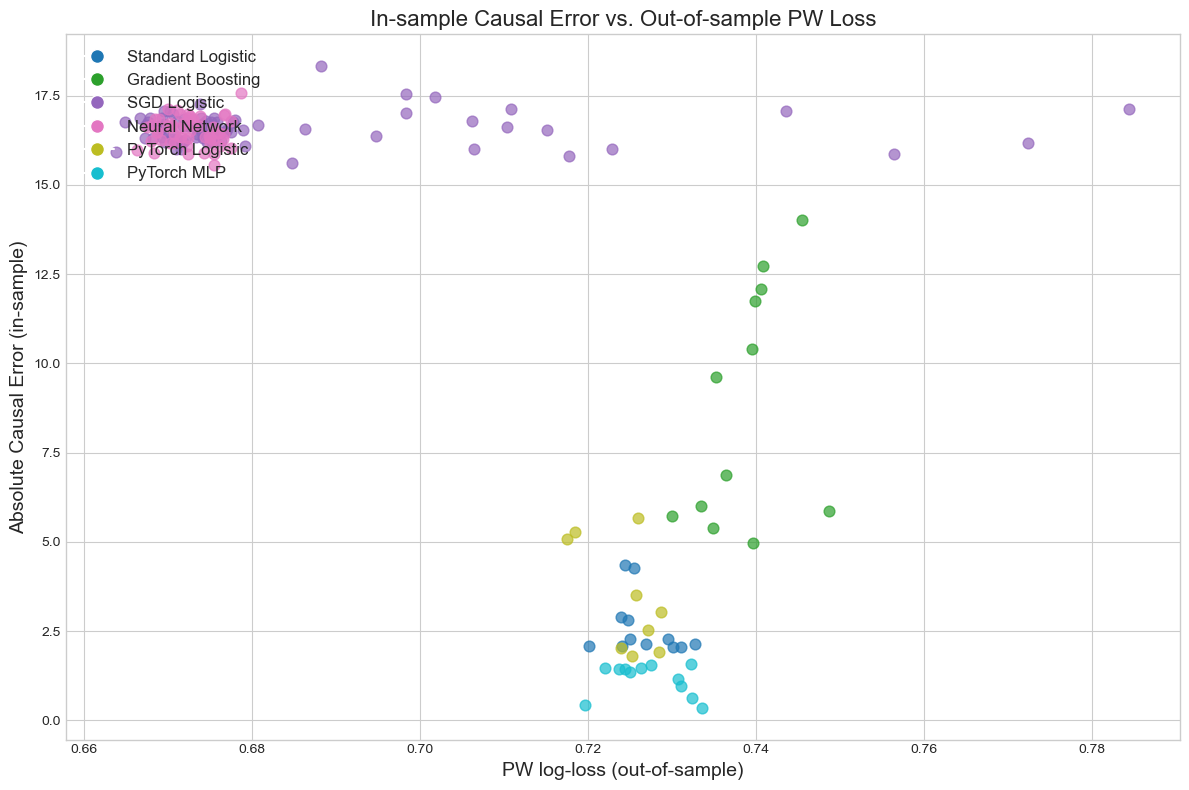

In [5]:
def main():
    # Generate Kang-Schafer data
    print("Generating Kang-Schafer data...")
    df = generate_kang_schafer_binary(n=2000, seed=42, misspecified=False)
    print(f"Generated data with {len(df)} observations")
    print(f"True ATE: {true_ate(df):.4f}")
    
    # Set up hyperparameter grids for different models
    # Expanded parameter options for a 15-minute run
    
    # 1. Standard Logistic Regression (for baseline)
    standard_logit_params = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear']
    }
    
    # 2. SGD Logistic Regression
    sgd_logit_params = {
        'loss': ['log_loss'],
        'penalty': ['l1', 'l2'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'optimal', 'adaptive'],
        'eta0': [0.001, 0.01, 0.1]
    }
    
    # 3. Neural Network with SGD
    neural_net_params = {
        'hidden_layer_sizes': [(10,), (20,), (10, 5)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'max_iter': [200]
    }
    
    # 4. Gradient Boosting
    boosting_params = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [2, 3, 4]
    }
    
    # 5. PyTorch models (if available)
    torch_logistic_params = {
        'learning_rate': [0.001, 0.01, 0.1],
        'l2_reg': [0.0001, 0.001, 0.01],
        'epochs': [50]
    }
    
    torch_mlp_params = {
        'hidden_dims': [[16], [32], [16, 8]],
        'learning_rate': [0.001, 0.01],
        'l2_reg': [0.0001, 0.001],
        'epochs': [50]
    }
    
    # Run hyperparameter tuning
    all_results = {}
    
    # 1. Standard Logistic Regression (for baseline)
    print("\nTuning Standard Logistic Regression...")
    std_logit_results = cross_validate_hyperparams(
        df, 'logit', standard_logit_params, 
        method_name='Standard Logistic',
        n_folds=5, seed=42
    )
    all_results['Standard Logistic'] = std_logit_results
    
    # 2. Gradient Boosting
    print("\nTuning Gradient Boosting...")
    boosting_results = cross_validate_hyperparams(
        df, 'boosting', boosting_params, 
        method_name='Gradient Boosting',
        n_folds=5, seed=42
    )
    all_results['Gradient Boosting'] = boosting_results
    
    # 3. SGD Logistic Regression
    print("\nTuning SGD Logistic Regression...")
    sgd_results = cross_validate_hyperparams(
        df, 'logit', sgd_logit_params, 
        method_name='SGD Logistic',
        n_folds=5, use_sgd=True, seed=42
    )
    all_results['SGD Logistic'] = sgd_results
    
    # 4. Neural Network with SGD
    print("\nTuning Neural Network...")
    nn_results = cross_validate_hyperparams(
        df, 'neural_net', neural_net_params, 
        method_name='Neural Network',
        n_folds=5, use_sgd=True, seed=42
    )
    all_results['Neural Network'] = nn_results
    
    # 5. PyTorch models (if available)
    if TORCH_AVAILABLE:
        print("\nTuning PyTorch Logistic Regression...")
        torch_logistic_results = cross_validate_hyperparams(
            df, 'logistic', torch_logistic_params, 
            method_name='PyTorch Logistic',
            n_folds=5, use_torch=True, seed=42
        )
        all_results['PyTorch Logistic'] = torch_logistic_results
        
        print("\nTuning PyTorch MLP...")
        torch_mlp_results = cross_validate_hyperparams(
            df, 'mlp', torch_mlp_params, 
            method_name='PyTorch MLP',
            n_folds=5, use_torch=True, seed=42
        )
        all_results['PyTorch MLP'] = torch_mlp_results
    
    # Generate combined performance plots
    best_configs = generate_model_performance_plots(all_results)
    
    # Set up methods for ROC curve comparison
    methods_to_eval = []
    
    # Add each method with its best configuration
    for method_name, best_config in best_configs.items():
        # Extract parameters for this method
        params = {k: v for k, v in best_config.items() 
                 if k not in ['ate_error', 'in_sample_logloss', 'out_sample_logloss', 'method']}
        
        # Determine the base method and whether to use SGD or PyTorch
        use_sgd = False
        use_torch = False
        
        if method_name == 'SGD Logistic' or method_name == 'Neural Network':
            use_sgd = True
            base_method = 'logit' if method_name == 'SGD Logistic' else 'neural_net'
        elif method_name == 'PyTorch Logistic' or method_name == 'PyTorch MLP':
            use_torch = True
            base_method = 'logistic' if method_name == 'PyTorch Logistic' else 'mlp'
        elif method_name == 'Gradient Boosting':
            base_method = 'boosting'
        else:  # Standard Logistic
            base_method = 'logit'
        
        methods_to_eval.append((
            method_name,
            {'method': base_method, 'params': params, 'use_sgd': use_sgd, 'use_torch': use_torch}
        ))
    
    # Generate ROC curves
    print("\nGenerating ROC curves...")
    final_model_evaluation(df, methods_to_eval)
    
    print("\nHyperparameter tuning complete. Results saved to 'tuning_results' directory.")

if __name__ == "__main__":
    main()